In [1]:
import numpy as np
import higra as hg
from functools import partial
from scipy.cluster.hierarchy import fcluster

from ultrametric.optimization import UltrametricFitting
from ultrametric.data import load_datasets, show_datasets
from ultrametric.graph import build_graph, show_graphs
from ultrametric.utils import Experiments
from ultrametric.evaluation import eval_clustering

# The following line requires that a C++14 compiler be installed
# On Windows, you should probably run
#   c:\Program Files (x86)\Microsoft Visual Studio\2017\Enterprise\VC\Auxiliary\Build\vcvars64.bat
# to properly setup all environment variables
from ultrametric.loss import loss_closest, loss_closest_and_cluster_size, make_triplets, loss_closest_and_triplet, loss_dasgupta

## Toy data

In [2]:
sets = load_datasets(n_samples=200, n_labeled=20)
exp = Experiments(sets)

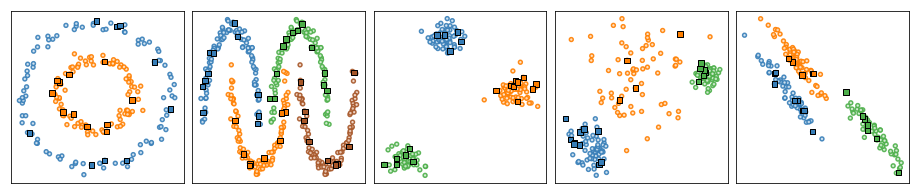

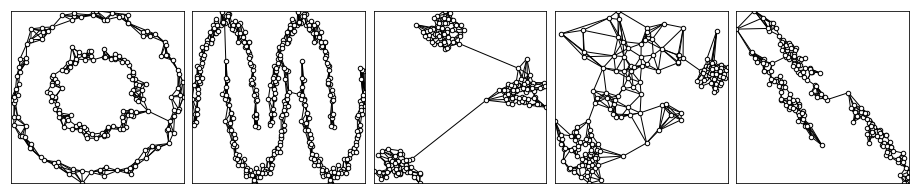

In [3]:
show_datasets(sets, show_labeled=True)
show_graphs(sets, "knn-mst")

## Test function

In [4]:
def run_test(exp, method_name, method):

    for set_name in exp.sets:
        X, y, n_clusters, labeled = exp.get_data(set_name)
        
        A = build_graph(X, 'knn-mst', mst_weight=1)
        graph, edge_weights = hg.adjacency_matrix_2_undirected_graph(A)
        
        hierarchy = method(X, labeled, y[labeled], graph, edge_weights)
        
        Z = hg.binary_hierarchy_to_scipy_linkage_matrix(*hierarchy)
        y_prediction = fcluster(Z, n_clusters, criterion='maxclust') - 1
        
        exp.add_results(method_name, set_name, y=y_prediction, linkage=Z)

        scores = eval_clustering( y, y_prediction)
        d_purity = hg.dendrogram_purity(hierarchy[0], y)
        print('{:10s} - {:7s} - {:.4f} - {:.4f} - {:.4f} - {:.4f} - {:.4f}'.format(method_name, set_name, *scores, d_purity))

# Agglomerative Clustering

method     - set     - acc    - pur    - nmi    - randi  - dendpur
average    - circles - 0.5050 - 0.5050 - 0.0235 - 0.0000 - 0.8259
average    - moons   - 0.7500 - 0.7500 - 0.8660 - 0.7127 - 0.9822
average    - blobs   - 1.0000 - 1.0000 - 1.0000 - 1.0000 - 1.0000
average    - varied  - 0.3400 - 0.3450 - 0.0420 - 0.0000 - 0.7993
average    - aniso   - 0.3400 - 0.3450 - 0.0420 - 0.0000 - 0.9194


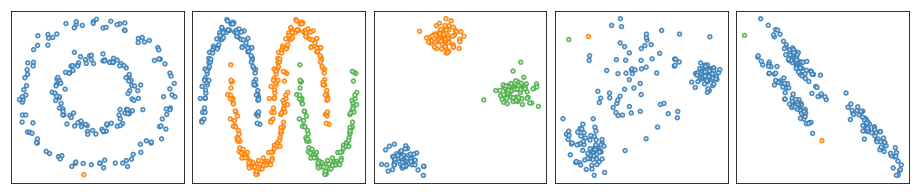

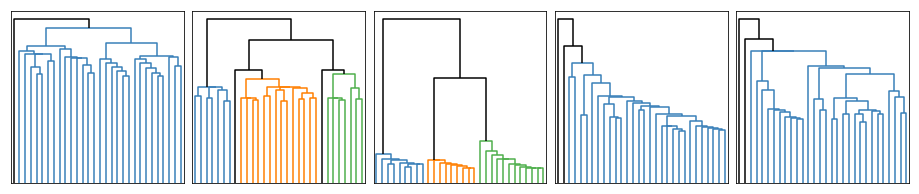

method     - set     - acc    - pur    - nmi    - randi  - dendpur
ward       - circles - 0.7350 - 0.7350 - 0.3246 - 0.2181 - 0.7757
ward       - moons   - 0.8150 - 0.8150 - 0.7491 - 0.6508 - 0.8152
ward       - blobs   - 1.0000 - 1.0000 - 1.0000 - 1.0000 - 1.0000
ward       - varied  - 0.9950 - 0.9950 - 0.9763 - 0.9850 - 0.9925
ward       - aniso   - 0.8700 - 0.8700 - 0.7675 - 0.6890 - 0.8744


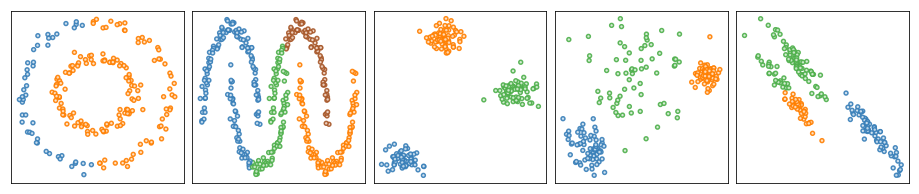

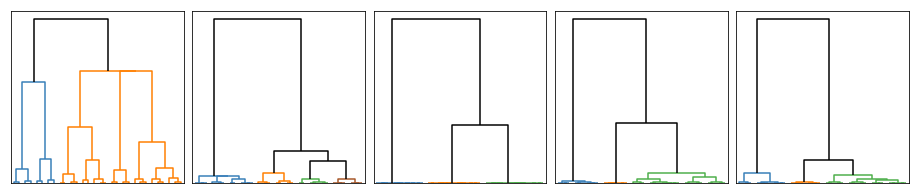

In [5]:
methods = {
    'average': lambda X, labeled, y_labeled, graph, edge_weights: hg.binary_partition_tree_average_linkage(graph, edge_weights),
    'ward': lambda X, labeled, y_labeled, graph, edge_weights: hg.binary_partition_tree_ward_linkage(graph, X)
}

for method_name, method in methods.items():
    print('{:10s} - {:7s} - {:6s} - {:6s} - {:6s} - {:6s} - {:6s}'.format("method", "set", "acc", "pur", "nmi", "randi", "dendpur"))
    run_test(exp, method_name, method)
    exp.show(method_name, ["clustering", "dendrogram"])

# Closest ultrametric fitting

method     - set     - acc    - pur    - nmi    - randi  - dendpur
closest    - circles - 0.5050 - 0.5050 - 0.0235 - 0.0000 - 0.8106
closest    - moons   - 0.7500 - 0.7500 - 0.8660 - 0.7127 - 0.9833
closest    - blobs   - 1.0000 - 1.0000 - 1.0000 - 1.0000 - 1.0000
closest    - varied  - 0.3400 - 0.3450 - 0.0420 - 0.0000 - 0.8012
closest    - aniso   - 0.3400 - 0.3450 - 0.0420 - 0.0000 - 0.9194


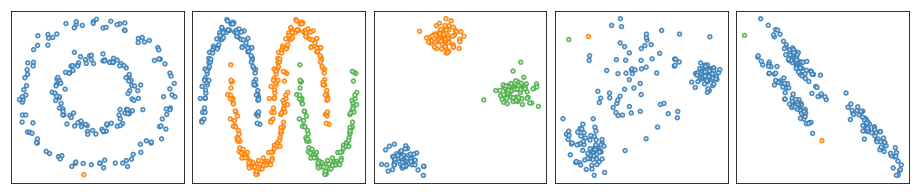

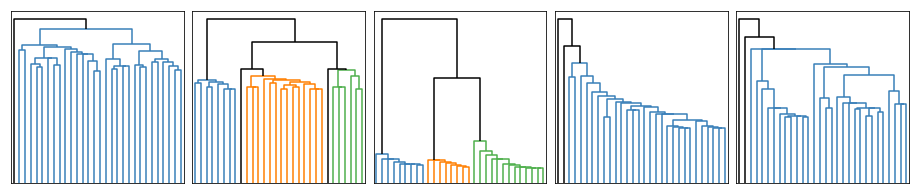

In [6]:
def closest_ultrametric(X, labeled, y_labeled, graph, edge_weights):
    
    optim = UltrametricFitting(500, 0.1, loss_closest)
    ultrametric = optim.fit(graph, edge_weights)
    
    return hg.bpt_canonical(graph, ultrametric)

print('{:10s} - {:7s} - {:6s} - {:6s} - {:6s} - {:6s} - {:6s}'.format("method", "set", "acc", "pur", "nmi", "randi", "dendpur"))
run_test(exp, "closest", closest_ultrametric)
exp.show("closest", ["clustering", "dendrogram"])

# Closest ultrametric fitting + Cluster size regularization

method       - set     - acc    - pur    - nmi    - randi  - dendpur
closest+size - circles - 0.7500 - 0.7500 - 0.3456 - 0.2472 - 0.8084
closest+size - moons   - 1.0000 - 1.0000 - 1.0000 - 1.0000 - 1.0000
closest+size - blobs   - 1.0000 - 1.0000 - 1.0000 - 1.0000 - 1.0000
closest+size - varied  - 0.9350 - 0.9350 - 0.8041 - 0.8181 - 0.9246
closest+size - aniso   - 0.9950 - 0.9950 - 0.9763 - 0.9849 - 0.9921


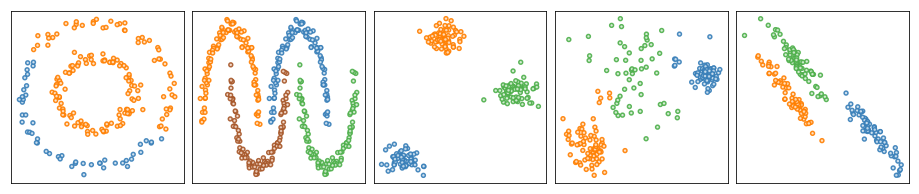

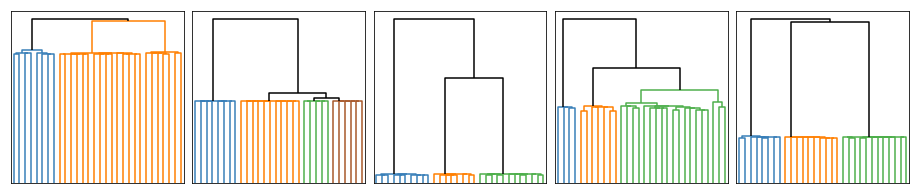

In [7]:
def closest_and_cluster_size_ultrametric(X, labeled, y_labeled, graph, edge_weights):

    loss = partial(loss_closest_and_cluster_size, top_nodes=10)

    optim = UltrametricFitting(500, 0.1, loss)
    ultrametric = optim.fit(graph, edge_weights)
    
    return hg.bpt_canonical(graph, ultrametric)

print('{:12s} - {:7s} - {:6s} - {:6s} - {:6s} - {:6s} - {:6s}'.format("method", "set", "acc", "pur", "nmi", "randi", "dendpur"))
run_test(exp, "closest+size", closest_and_cluster_size_ultrametric)
exp.show("closest+size", ["clustering", "dendrogram"])

# Closest ultrametric fitting + Triplet regularization

method     - set     - acc    - pur    - nmi    - randi  - dendpur
closest+triplet - circles - 1.0000 - 1.0000 - 1.0000 - 1.0000 - 1.0000
closest+triplet - moons   - 0.9925 - 0.9925 - 0.9756 - 0.9802 - 0.9863
closest+triplet - blobs   - 1.0000 - 1.0000 - 1.0000 - 1.0000 - 1.0000
closest+triplet - varied  - 0.9900 - 0.9900 - 0.9527 - 0.9700 - 0.9883
closest+triplet - aniso   - 0.9950 - 0.9950 - 0.9763 - 0.9849 - 0.9950


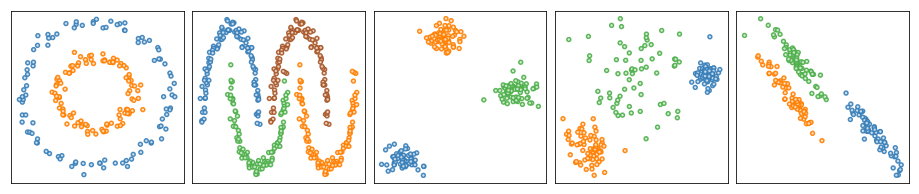

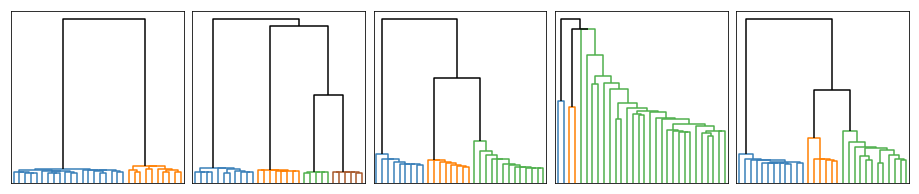

In [8]:
def closest_and_triplet(X, labeled, y_labeled, graph, edge_weights):
    triplets = make_triplets(y_labeled, labeled)
    loss = partial(loss_closest_and_triplet, triplets=triplets, margin=1)
    optim = UltrametricFitting(500, 0.1, loss)
    ultrametric = optim.fit(graph, edge_weights)
    
    return hg.bpt_canonical(graph, ultrametric)

print('{:10s} - {:7s} - {:6s} - {:6s} - {:6s} - {:6s} - {:6s}'.format("method", "set", "acc", "pur", "nmi", "randi", "dendpur"))
run_test(exp, "closest+triplet", closest_and_triplet)
exp.show("closest+triplet", ["clustering", "dendrogram"])

# Dasgupta  ultrametric fitting

method     - set     - acc    - pur    - nmi    - randi  - dendpur
dasgupta   - circles - 1.0000 - 1.0000 - 1.0000 - 1.0000 - 1.0000
dasgupta   - moons   - 0.8925 - 0.8925 - 0.8572 - 0.7801 - 0.8944
dasgupta   - blobs   - 1.0000 - 1.0000 - 1.0000 - 1.0000 - 1.0000
dasgupta   - varied  - 0.9900 - 0.9900 - 0.9527 - 0.9700 - 0.9799
dasgupta   - aniso   - 0.9950 - 0.9950 - 0.9763 - 0.9849 - 0.9929


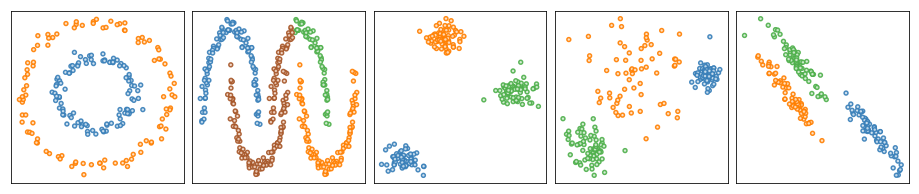

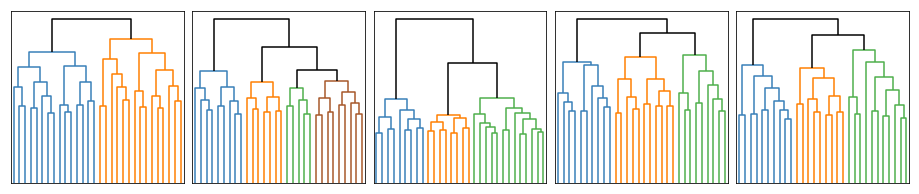

In [14]:
def dasgupta(X, labeled, y_labeled, graph, edge_weights):
    optim = UltrametricFitting(500, 0.1, partial(loss_dasgupta, sigmoid_param=50))
    edge_weights = edge_weights / np.max(edge_weights)
    ultrametric = optim.fit(graph, edge_weights)
    
    return hg.bpt_canonical(graph, ultrametric)

print('{:10s} - {:7s} - {:6s} - {:6s} - {:6s} - {:6s} - {:6s}'.format("method", "set", "acc", "pur", "nmi", "randi", "dendpur"))
run_test(exp, "dasgupta", dasgupta)
exp.show("dasgupta", ["clustering", "dendrogram"])